# 1.Install PennyLane for quantum operations

In [1]:
%%capture

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib
!pip install torchvision

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
#import tensorflow as tf
#from tensorflow import keras
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
import torch
import torch.utils.data as data
#import torchvision.transforms as transforms
from torchvision import datasets, transforms

# 2.Prepare dataset - hurricane

In [4]:
data_flag = 'hurricane'

## 2.1.Read the data, preprocess and encapsulate into dataloader form

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
TRAIN_DATA_PATH = "./raw_hurricane_dataset/train_another/"
TEST_DATA_PATH = "./raw_hurricane_dataset/test/"



In [7]:
%%time
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=data_transform)
test_data = datasets.ImageFolder(root=TEST_DATA_PATH, transform=data_transform)


CPU times: user 4.5 ms, sys: 14.9 ms, total: 19.4 ms
Wall time: 62.6 ms


In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

## 2.2.Visualize

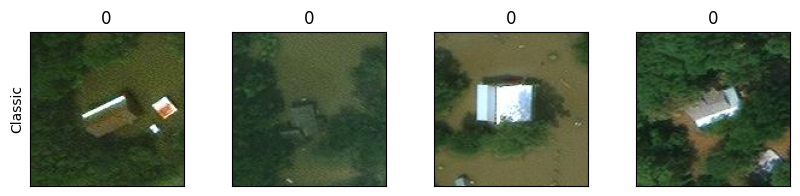

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

n_sample_shape = (1, 4)
count = 0
fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

for batch_idx, (data, target) in enumerate(test_loader):
    if count == n_sample_shape[0]*n_sample_shape[1]:
        break

    axes[0].set_ylabel("Classic")
    axes[count % n_sample_shape[1]].imshow(data[0].permute(1, 2, 0))
    axes[count % n_sample_shape[1]].set_xticks([])
    axes[count % n_sample_shape[1]].set_yticks([])
    axes[count % n_sample_shape[1]].set_title(target.item())

    count += 1


In [10]:
# train_images, train_labels = zip(*[batch for batch in train_loader])
# test_images, test_labels = zip(*[batch for batch in test_loader])

In [11]:
# print(len(train_labels))
# print(len(test_labels))

In [12]:
# import numpy as np
# print(np.array(train_images[0]).shape)
# print(np.array(test_images[0]).shape)

In [13]:
# train_images, train_labels = next(iter(train_loader))

## 2.3.Alternatively - to get compatibility with the "legacy" QC-preprocessing code

In [14]:
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [15]:
# train_images_original = next(iter(train_loader))[0].numpy()
# train_labels_original = next(iter(train_loader))[1].numpy()
# test_images_original = next(iter(test_loader))[0].numpy()
# test_labels_original = next(iter(test_loader))[1].numpy()

# loaded_train_dataset =  next(iter(train_loader))
# loaded_test_dataset =  next(iter(test_loader))

# train_images_original = loaded_train_dataset[0].numpy()
# train_labels_original = loaded_train_dataset[1].numpy()
# test_images_original = loaded_test_dataset[0].numpy()
# test_labels_original = loaded_test_dataset[1].numpy()

In [16]:
# print(train_images_original.shape)
# print(train_labels_original.shape)
# print(test_images_original.shape)
# print(test_labels_original.shape)

# 3.Quantum - Pre-processing

In [17]:
import param
import datetime as dt

class Parameters(param.Parameterized):
    #x                       = param.Parameter(default=3.14,doc="X position")
    #y                       = param.Parameter(default="Not editable",constant=True)
    #string_value            = param.String(default="str",doc="A string")
    #num_int                 = param.Integer(50000,bounds=(-200,100000))
    #unbounded_int           = param.Integer(23)
    #float_with_hard_bounds  = param.Number(8.2,bounds=(7.5,10))
    #float_with_soft_bounds  = param.Number(0.5,bounds=(0,None),softbounds=(0,2))
    #unbounded_float         = param.Number(30.01,precedence=0)
    #hidden_parameter        = param.Number(2.718,precedence=-1)
    #integer_range           = param.Range(default=(3,7),bounds=(0, 10))
    #float_range             = param.Range(default=(0,1.57),bounds=(0, 3.145))
    #dictionary              = param.Dict(default={"a":2, "b":9})
    select_DEVICE           = param.ObjectSelector(default="CPU",objects=["CPU", "GPU"])
    select_AXES             = param.ObjectSelector(default="X",objects=["X", "XY", "XYZ"])
    select_RF               = param.ObjectSelector(default="2", objects=["2","3"])
    select_STRIDE           = param.ObjectSelector(default="2", objects=["1","2"])
    select_subset_START     = param.String(default="0",doc="Start of TRAIN subset range:")
    select_subset_RANGE     = param.String(default="4",doc="TRAIN subset range:")
    #select_TRAIN_subset_end = param.String(default="4",doc="End of TRAIN subset range:")
    select_subset           = param.ObjectSelector(default="TRAIN",objects=["TRAIN", "TEST"])

    ##select_TEST_subset_START = param.String(default="0",doc="Start of TEST subset range:")
    ##select_TEST_subset_RANGE = param.String(default="4",doc="TEST subset range:")
    #select_TEST_subset_end = param.String(default="4",doc="End of TEST subset range:")


class Example(Parameters):
    """An example Parameterized class"""
    #timestamps = []

    #boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
    #color                   = param.Color(default='#FFFFFF')
    #date                    = param.Date(dt.datetime(2017, 1, 1),
    #                                     bounds=(dt.datetime(2017, 1, 1), dt.datetime(2017, 2, 1)))
    select_string           = param.ObjectSelector(default="yellow",objects=["red","yellow","green"])
    #select_fn               = param.ObjectSelector(default=list,objects=[list,set,dict])
    int_list                = param.ListSelector(default=[3,5], objects=[1,3,5,7,9],precedence=0.5)
    #single_file             = param.FileSelector(path='../../*/*.py*',precedence=0.5)
    #multiple_files          = param.MultiFileSelector(path='../../*/*.py?',precedence=0.5)
    #record_timestamp        = param.Action(lambda x: x.timestamps.append(dt.datetime.now()),
    #                                       doc="""Record timestamp.""",precedence=0.7)

#Example.num_int
#Parameters.select_DEVICE

## 3.1.MANUALLY select parameters

In [18]:
# Set all parameters

import panel as pn

pn.extension()

base = Parameters()
#pn.Row(Example.param, base.param)
pn.Row(base.param)

Row
    [0] Column(margin=(5, 10), name='Parameters')
        [0] StaticText(value='<b>Parameters</b>')
        [1] Select(options=OrderedDict([('CPU', ...]), value='CPU')
        [2] Select(options=OrderedDict([('X', ...]), value='X')
        [3] Select(options=OrderedDict([('2', ...]), value='2')
        [4] Select(options=OrderedDict([('1', ...]), value='2')
        [5] TextInput(description='Start of TRAIN s..., name='Select subset START', value='0')
        [6] TextInput(description='TRAIN subset range:', name='Select subset RANGE', value='4')
        [7] Select(options=OrderedDict([('TRAIN', ...]), value='TRAIN')

### Check selection of parameters!

In [19]:
#DEVICE = 'GPU'
DEVICE = base.select_DEVICE # 'CPU'
print("DEVICE:", DEVICE)
AXES = base.select_AXES # "XYZ"
print("AXES:", AXES)
RF = int(base.select_RF) # RF = sqrt(WIRES) # Quanvolutional Receptive Field = RF*RF = WIRES
print("RF:", RF)
WIRES = RF*RF # 4 # 9
print("WIRES:", WIRES)
n_stride = int(base.select_STRIDE) # 2
print("STRIDE:", n_stride)

SUBSET = base.select_subset # 'TRAIN'
print("SUBSET:", SUBSET)

n_layers = 1    # Number of random layers
print("n_layers:", n_layers)

# n_train = 4 # 4096 # 4*1024 # 8*1024 #128 #2048 # 512 #50    # Size of the train dataset
n_start = int(base.select_subset_START)
print("n_start:", n_start)
n_range = int(base.select_subset_RANGE)
print("n_range:", n_range)
n_end = n_start + n_range
print("n_end:", n_end)

# n_test =  4 # 1024 # 1024 #32 #128 #30     # Size of the test dataset

SAVE_PATH = "/mnt/d/PHD/hurricane_data_results/" # Data saving folder
#SAVE_PATH = "./RESULTS/" # Data saving folder
#SAVE_PATH = "/data1/QC/RESULTS/" # Data saving folder

#PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
#np.random.seed(0)           # Seed for NumPy random number generator
#tf.random.set_seed(0)       # Seed for TensorFlow random number generator

# SIZE = train_images_original.shape[3]
# print("SIZE:", SIZE)

DEVICE: CPU
AXES: X
RF: 2
WIRES: 4
STRIDE: 2
SUBSET: TRAIN
n_layers: 1
n_start: 0
n_range: 4
n_end: 4


In [20]:
def get_subset(dataset, n_start, n_range, n_end):
  ids = list(range(n_start, n_end))
  print(ids)
  subset = torch.utils.data.Subset(dataset, ids)
  loader = torch.utils.data.DataLoader(subset, batch_size=n_range, shuffle=False)
    
  subset_images = next(iter(loader))[0].numpy()
  subset_labels = next(iter(loader))[1].numpy()

  print(subset_images.shape)
    
  # Normalize pixel values within 0 and 1
  ###subset_images = subset_images / 255

  classic_subset_images = subset_images

  # Add extra dimension for convolution channels
  #train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
  subset_images = np.expand_dims(subset_images, axis=-1)

  print("For quantum:")
  print("subset_images.shape:", subset_images.shape)

  print("For classic:")
  print("classic_subset_images.shape:", classic_subset_images.shape)

  return subset_images, subset_labels, classic_subset_images

In [21]:
# Reduce dataset size

# Convert TRAIN
if SUBSET == "TRAIN": subset_images, subset_labels, classic_subset_images = get_subset(train_data, n_start, n_range, n_end)

# Convert TEST
if SUBSET == "TEST": subset_images, subset_labels, classic_subset_images = get_subset(test_data, n_start, n_range, n_end)

SIZE = subset_images.shape[3]
print("SIZE:", SIZE)

[0, 1, 2, 3]
(4, 3, 128, 128)
For quantum:
subset_images.shape: (4, 3, 128, 128, 1)
For classic:
classic_subset_images.shape: (4, 3, 128, 128)
SIZE: 128


In [22]:
## If the NVIDIA cuQuantum libraries are available,
## the above device will allow all operations to be perfomed on a CUDA capable GPU of generation SM 7.0 (Volta) and greater.
if DEVICE == 'GPU':
    dev = qml.device("lightning.gpu", wires=WIRES)
else:
    dev = qml.device("default.qubit", wires=WIRES)

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, WIRES))

@qml.qnode(dev)
def circuitX(phi):
    # Encoding of 4 classical input values
    for j in range(WIRES):
        qml.RX(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(WIRES)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(WIRES)]

@qml.qnode(dev)
def circuitY(phi):
    # Encoding of 4 classical input values
    for j in range(WIRES):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(WIRES)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(WIRES)]

@qml.qnode(dev)
def circuitZ(phi):
    # Encoding of 4 classical input values
    for j in range(WIRES):
        qml.RZ(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(WIRES)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(WIRES)]

@qml.qnode(dev)
def circuitXY(phi):
    # Encoding of 4 classical input values
    for j in range(WIRES):
        qml.RX(np.pi * phi[j], wires=j)
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(WIRES)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(WIRES)]

@qml.qnode(dev)
def circuitXYZ(phi):
    # Encoding of 4 classical input values
    for j in range(WIRES):
        qml.RX(np.pi * phi[j], wires=j)
        qml.RY(np.pi * phi[j], wires=j)
        qml.RZ(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(WIRES)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(WIRES)]

### WIRES = 4

In [23]:
# X, Time: 40s per image.

def quanv_stride1x1_color(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    # out = np.zeros((14, 14, 4)) # mnist
    # out = np.zeros((16, 16, 3, 4)) # cifar
    #out = np.zeros((32, 32, 3, 4)) # cifar
    #out = np.zeros((28, 28, 3, 4)) # Path
    #out = np.zeros((28-RF+1, 28-RF+1, 3, WIRES)) # Path
    out = np.zeros((SIZE-RF+1, SIZE-RF+1, 3, WIRES)) # Path

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    # for j in range(0, 28, 2):  # mnist
    # for j in range(0, 31, 1): #2): # stride1x1
    for j in range(0, SIZE-RF+1, 1): #2): # Path
        # for k in range(0, 28, 2):  # mnist
        # for k in range(0, 31, 1): #2): # stride1x1
        for k in range(0, SIZE-RF+1, 1): #2): # Path
            q_results = np.zeros((3, 4))
            for color in range(3):  # cifar - colors
              # Process a squared 2x2 region of the image with a quantum circuit
              phi = [
                    image[j, k, color],
                    image[j, k + 1, color],
                    image[j + 1, k, color],
                    image[j + 1, k + 1, color]
                    ]

              ##print(image[j, k, color])
              if AXES == "X": q_results[color] = circuitX(phi)
              if AXES == "XY": q_results[color] = circuitXY(phi)
              if AXES == "XYZ": q_results[color] = circuitXYZ(phi)

            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
              for color in range(3):  # cifar - colors
                #out[j // 2, k // 2, color, c] = q_results[color][c]
                out[j, k, color, c] = q_results[color][c] # stride1x1
    return out

In [24]:
# X, Time: 152s per image.

def quanv_stride2x2_color(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    # out = np.zeros((14, 14, 4)) # mnist
    # out = np.zeros((16, 16, 3, 4)) # cifar
    #out = np.zeros((14, 14, 3, 4)) # Path
    #out = np.zeros((28 // 2 - 1, 28 // 2 - 1, 3, WIRES)) # Path
    #out = np.zeros((SIZE // 2 - 1, SIZE // 2 - 1, 3, WIRES)) # Path
    out = np.zeros((SIZE // 2, SIZE // 2, 3, WIRES)) # Path

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    # for j in range(0, 28, 2):  # mnist
    # for j in range(0, 32, 2): # cifar
    for j in range(0, SIZE, 2): # Path
        # for k in range(0, 28, 2):  # mnist
        # for k in range(0, 32, 2):  # cifar
        for k in range(0, SIZE, 2):  # Path
            q_results = np.zeros((3, 4))
            for color in range(3):  # cifar - colors
              # Process a squared 2x2 region of the image with a quantum circuit
              phi = [
                    image[j, k, color],
                    image[j, k + 1, color],
                    image[j + 1, k, color],
                    image[j + 1, k + 1, color]
                    ]

              ##print(image[j, k, color])
              if AXES == "X": q_results[color] = circuitX(phi)
              if AXES == "XY": q_results[color] = circuitXY(phi)
              if AXES == "XYZ": q_results[color] = circuitXYZ(phi)
            ##print(q_results.shape)
            ##print(q_results[0])
            ##print(q_results[1])
            ##print(q_results[2])

            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
              for color in range(3):  # cifar - colors
                out[j // 2, k // 2, color, c] = q_results[color][c]
    return out

In [25]:
# X, Time: 556s per image.

def quanv_stride1x1(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    #out = np.zeros((14, 14, 4))
    #out = np.zeros((28, 28, 4)) # mnist
    out = np.zeros((32, 32, 4)) # cifar

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 31, 1): #2): # stride1x1
        for k in range(0, 31, 1): #2): # stride1x1
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuitX(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                #out[j // 2, k // 2, c] = q_results[c]
                out[j, k, c] = q_results[c] # stride1x1
    return out

### WIRES = 9

In [26]:
# X, Time: 884s per image.

def quanv_wire9_stride1x1_color(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    # out = np.zeros((14, 14, 4)) # mnist
    # out = np.zeros((16, 16, 3, 4)) # cifar
    #out = np.zeros((32, 32, 3, 4)) # cifar
    #out = np.zeros((28-RF+1, 28-RF+1, 3, WIRES)) # Path
    out = np.zeros((SIZE-RF+1, SIZE-RF+1, 3, WIRES))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    # for j in range(0, 28, 2):  # mnist
    # for j in range(0, 31, 1): #2): # stride1x1
    for j in range(0, (SIZE-RF+1), 1): #2): # Path
        # for k in range(0, 28, 2):  # mnist
        # for k in range(0, 31, 1): #2): # stride1x1
        for k in range(0, (SIZE-RF+1), 1): #2): # Path
            q_results = np.zeros((3, WIRES))
            for color in range(3):  # cifar - colors
              # Process a squared 2x2 region of the image with a quantum circuit
              phi = [
                  image[j, k, color],
                  image[j, k + 1, color],
                  image[j, k + 2, color],
                  image[j + 1, k, color],
                  image[j + 1, k + 1, color],
                  image[j + 1, k + 2, color],
                  image[j + 2, k, color],
                  image[j + 2, k + 1, color],
                  image[j + 2, k + 2, color]
                  ]

              if AXES == "X": q_results[color] = circuitX(phi)
              if AXES == "XY": q_results[color] = circuitXY(phi)
              if AXES == "XYZ": q_results[color] = circuitXYZ(phi)

            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(WIRES):
              for color in range(3):  # cifar - colors
                #out[j // 2, k // 2, color, c] = q_results[color][c]
                out[j, k, color, c] = q_results[color][c] # stride1x1
    return out

In [27]:
# X, Time: 225s per image.

def quanv_wire9_stride2x2_color(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    # out = np.zeros((14, 14, 4)) # mnist
    # out = np.zeros((16, 16, 3, 4)) # cifar
    #out = np.zeros((32, 32, 3, 4)) # cifar
    #out = np.zeros((28 // 2 - 1, 28 // 2 - 1, 3, WIRES)) # Path
    out = np.zeros((SIZE // 2 - 1, SIZE // 2 - 1, 3, WIRES))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    # for j in range(0, 28, 2):  # mnist
    # for j in range(0, 31, 1): #2): # stride1x1
    for j in range(0, (SIZE-RF+1), n_stride): # stride2x2 - MedMNIST
        # for k in range(0, 28, 2):  # mnist
        # for k in range(0, 31, 1): #2): # stride1x1
        for k in range(0, (SIZE-RF+1), n_stride): # stride2x2 - MedMNIST
            q_results = np.zeros((3, WIRES))
            for color in range(3):  # cifar - colors
              # Process a squared 2x2 region of the image with a quantum circuit
              phi = [
                  image[j, k, color],
                  image[j, k + 1, color],
                  image[j, k + 2, color],
                  image[j + 1, k, color],
                  image[j + 1, k + 1, color],
                  image[j + 1, k + 2, color],
                  image[j + 2, k, color],
                  image[j + 2, k + 1, color],
                  image[j + 2, k + 2, color]
                  ]

              if AXES == "X": q_results[color] = circuitX(phi)
              if AXES == "XY": q_results[color] = circuitXY(phi)
              if AXES == "XYZ": q_results[color] = circuitXYZ(phi)

            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(WIRES):
              for color in range(3):  # cifar - colors
                out[j // 2, k // 2, color, c] = q_results[color][c] # stride2x2
                #out[j, k, color, c] = q_results[color][c] # stride1x1
    return out

## 3.2.Convert to Quantum

In [28]:
def convert_quantum(subset_images, subset_type):
    q_subset_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in tqdm(enumerate(subset_images)):
        print("{}/{}        ".format(idx + 1, n_range), end="\r")

        # For Hurricane dataset ONLY
        #print(img.shape)
        img = np.transpose(img, (1, 2, 0, 3))
        #print(img.shape)

        if WIRES == 9:
          if n_stride == 1:
            print("Start: quanv_wire9_stride1x1_color ...")
            q_subset_images.append(quanv_wire9_stride1x1_color(img))
          if n_stride == 2:
            print("Start: quanv_wire9_stride2x2_color ...")
            q_subset_images.append(quanv_wire9_stride2x2_color(img))

        if WIRES == 4:
          if n_stride == 1:
            print("Start: quanv_stride1x1_color ...")
            q_subset_images.append(quanv_stride1x1_color(img))
          if n_stride == 2:
            print("Start: quanv_stride2x2_color ...")
            q_subset_images.append(quanv_stride2x2_color(img))

    q_subset_images = np.asarray(q_subset_images)

    # Save pre-processed images
    q_subset_images_filename = SAVE_PATH + "QNN_" + subset_type + "_" + DEVICE + '_' + data_flag + "_W" + str(WIRES) + "_" + AXES + "_S" + str(n_start) + "_E" + str(n_end) + "_s" + str(n_stride) + ".npy"
    np.save(q_subset_images_filename, q_subset_images)

    # Load pre-processed images
    #q_subset_images = np.load(q_subset_images_filename)

    print("len(q_train_images):",len(q_subset_images))

    return q_subset_images_filename, q_subset_images

In [29]:
# %%time
# Convert TRAIN
# if SUBSET == "TRAIN": q_subset_images_filename, q_subset_images = convert_quantum(subset_images, "TRAIN")

# Convert TEST
# if SUBSET == "TEST": q_subset_images_filename, q_subset_images = convert_quantum(subset_images, "TEST")

## 3.3.Visualize

In [30]:
# n_colors = 3
# n_samples = 4
# n_channels = WIRES
# S = 0
# #fig, axes = plt.subplots(n_colors + 1 + n_channels, n_samples, figsize=(8, 12))
# fig, axes = plt.subplots(n_channels+1, n_samples, figsize=(8,16))
# for k in range(n_samples):
#     axes[0, 0].set_ylabel("Input")
#     if k != 0:
#         axes[0, k].yaxis.set_visible(False)

#     #axes[0, k].imshow(classic_subset_images[k+S, :, :]) # cifar - color
#     #print(classic_subset_images[k+S, :, :].shape)
#     img = np.transpose(classic_subset_images[k+S, :, :], (1, 2, 0))
#     #print(img.shape)
#     axes[0, k].imshow(img) # cifar - color

#     ##axes[1, 0].set_ylabel("Red")
#     ##axes[1, k].imshow(c_train_images[k, :, :, 0], cmap="Reds") # mnist - grayscale
#     ##axes[2, 0].set_ylabel("Green")
#     ##axes[2, k].imshow(c_train_images[k, :, :, 1], cmap="Greens")
#     ##axes[3, 0].set_ylabel("Blue")
#     ##axes[3, k].imshow(c_train_images[k, :, :, 2], cmap="Blues")

#     # Plot all output channels
#     for c in range(n_channels):
#         #axes[c + n_colors + 1, 0].set_ylabel("Output [ch. {}]".format(c))
#         axes[c+1, 0].set_ylabel("Output [ch. {}]".format(c))
#         ##if k != 0:
#         ##    axes[c, k].yaxis.set_visible(False)
#         #axes[c + n_colors + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")
#         ##axes[c + n_colors + 1, k].imshow(q_train_images[k, :, :, :, c])

#         axes[c+1, k].imshow(q_subset_images[k+S, :, :, :, c])

# plt.tight_layout()
# plt.savefig(SAVE_PATH + "/QNN_" + SUBSET + "_" + DEVICE + '_' + data_flag + "_W" + str(WIRES) + "_" + AXES + "_S" + str(n_start) + "_E" + str(n_end) + "_s" + str(n_stride) + ".png")
# plt.show()

# Running automatically

In [31]:
import os

for x in range(61, 100):
    n_start = x * 100
    print("n_start:", n_start)
    n_range = 100
    print("n_range:", n_range)
    n_end = n_start + n_range
    print("n_end:", n_end)

    if SUBSET == "TRAIN": 
        subset_images, subset_labels, classic_subset_images = get_subset(train_data, n_start, n_range, n_end)
        q_subset_images_filename, q_subset_images= convert_quantum(subset_images, "TRAIN")
        
    # Convert TEST
    if SUBSET == "TEST": 
        subset_images, subset_labels, classic_subset_images = get_subset(test_data, n_start, n_range, n_end)
        q_subset_images_filename, q_subset_images= convert_quantum(subset_images, "TEST")

n_start: 6100
n_range: 100
n_end: 6200
[6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199]
(100, 3, 128, 128)
For quantum:
subset_images.shape: (100, 3, 128, 128, 1)
For classic:
classic_subset_images.shape: (100, 3, 128, 128)
Quantum pre-processing of train images:


0it [00:00, ?it/s]

Start: quanv_stride2x2_color ...


/tmp/ipykernel_1600/3820351499.py:30: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if AXES == "X": q_results[color] = circuitX(phi)
1it [01:06, 66.97s/it]

Start: quanv_stride2x2_color ...


1it [01:31, 91.97s/it]


KeyboardInterrupt: 

# 4.Save to Google Drive (before at your Google Drive, please, create QC/PREPROC folder there!)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import os

# zip_filename = "RESULTS_" + SUBSET + "_" + DEVICE + '_' + data_flag + "_W" + str(WIRES) + "_" + AXES + "_S" + str(n_start) + "_E" + str(n_end) + "_s" + str(n_stride) + ".zip"
# print(zip_filename)
# os.system("zip " + zip_filename + " ./*png ./*npy ")
# os.system("cp " + zip_filename + " /content/drive/MyDrive/QC/PREPROC/")

In [ ]:
# ! ls  -all /content/drive/MyDrive/QC/PREPROC/